In [1]:
#!pip install -U matplotlib #для функционирования bar_label
#%pip install -U seaborn #для функционирования histplot
import warnings
warnings.simplefilter('ignore')

# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

## Изучение данных

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

import tensorflow.keras as k
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("/datasets/users_behavior.csv")
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Согласно условию данные уже предобработаны

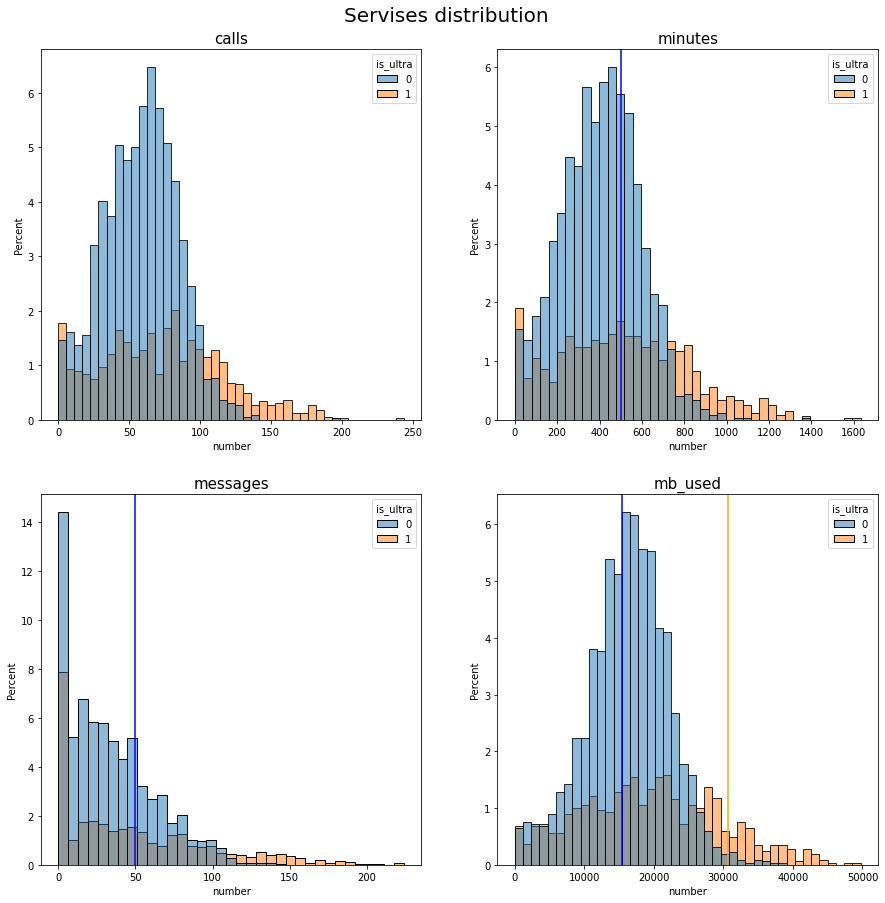

In [3]:
f, axs = plt.subplots(2,2, figsize=(15,15))
plt.suptitle('Servises distribution', fontsize=20, y=0.92)
axs = axs.ravel()
for i,col,limit in zip(range(4),df.columns[:-1],[[np.NaN, np.NaN],[500,np.NaN],[50,np.NaN],[15360,30720]]):
  # np.NaN в тех местах где потребляемое количесво значительно ниже лимита или лимит отсутсвует
  sns.histplot(ax=axs[i], data=df, x=col, hue='is_ultra', stat='percent').set_title(col, fontsize=15)
  axs[i].axvline(x=limit[0], color='b')
  axs[i].axvline(x=limit[1], color='orange')
  axs[i].set(xlabel='number')

## Подготовка данных

Как указано в условии, данные по тарифам из прошлого проекта. А значит, что от туда же мы можем взять дополнительную информацию, которая значительно улучшит точность моделей

Напомню  
<b>Описание тарифов  </b>  

<b>Тариф «Смарт» </b>   

Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  

Стоимость услуг сверх тарифного пакета:  
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута);  
2. сообщение: 3 рубля;
3. 1 Гб интернет-трафика: 200 рублей.


<b>Тариф «Ультра»  </b>  

Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  

Стоимость услуг сверх тарифного пакета:  
1. минута разговора: 1 рубль;  
2. сообщение: 1 рубль;  
3. 1 Гб интернет-трафика: 150 рублей.

Преобразуем на основе этого данные, чтобы получить более явные различия

In [4]:
df = np.ceil(df).astype(int) #округляем первоначальные данные

#цена за перерасход минут согласно тарифу
df['over_min'] = df.apply(lambda x: max(0,(np.ceil(x.minutes)-(x.is_ultra*2500+500))*(x.is_ultra*(-2)+3)), axis=1)
#цена за перерасход трафика согласно тарифу
df['over_mb'] = df.apply(lambda x: max(0,(np.ceil((np.ceil(x.mb_used)-(x.is_ultra*15360+15360))/1024)*(x.is_ultra*(-50)+200))), axis=1)
#цена за перерасход сообщений согласно тарифу
df['over_mes'] = df.apply(lambda x: max(0,(x.messages-(x.is_ultra*950+50))*(x.is_ultra*(-2)+3)), axis=1)
#оплата услуг клиента за месяц согласно тарифу
df['payment'] = (df.over_min+df.over_mb+df.over_mes+(df.is_ultra*1400+550)).astype(int)


df = df.drop(['over_mb', 'over_min', 'over_mes'], axis=1)

#перерасход трафика если бы клиент был на тарифе ultra
df['ultra_overlimit_gb'] = np.ceil((df.mb_used-30720)/1024)
#перерасход трафика если бы клиент был на тарифе smart
df['smart_overlimit_gb'] = np.ceil((df.mb_used-15360)/1024)
#перерасход минут если бы клиент был на тарифе ultra
df['ultra_overlimit_m'] = df.minutes-3000
#перерасход минут если бы клиент был на тарифе smart
df['smart_overlimit_m'] = df.minutes-500
#перерасход сообщений если бы клиент был на тарифе ultra
df['ultra_overlimit_mes'] = df.messages-1000
#перерасход сообщений если бы клиент был на тарифе smart
df['smart_overlimit_mes'] = df.messages-50

df = df.drop(['minutes','messages','mb_used'], axis=1)

df = df.clip(lower=0) #если лимиты не израсходованные значение =0

In [5]:
df

,calls,is_ultra,payment,ultra_overlimit_gb,smart_overlimit_gb,ultra_overlimit_m,smart_overlimit_m,ultra_overlimit_mes,smart_overlimit_mes
0,40,0,1649,0.0,5.0,0,0,0,33
1,85,0,2219,0.0,8.0,0,17,0,6
2,77,0,1858,0.0,6.0,0,0,0,36
3,106,1,1950,0.0,0.0,0,246,0,31
4,66,0,550,0.0,-0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3209,122,1,2700,5.0,20.0,0,411,0,0
3210,25,0,550,0.0,0.0,0,0,0,0
3211,97,0,1015,0.0,0.0,0,135,0,20
3212,64,0,3870,1.0,16.0,0,0,0,40


Сейчас для модели ежемесячная оплата была посчитана вручную, для пользователей архивными тарифами такую информацию а дальнейшем необходимо предоставить.  

Информация насколько потребляемые ресурсы превосходят установленные лимиты является более информативной чем "голые" счетчики

Подготовливаем выборку, которая не будет участвовать в создании моделей и будет использоваться только для окончательной оценки точности моделей

In [6]:
df_test = df.sample(frac=0.2, random_state=42)
final_test = df_test.drop('is_ultra', axis=1)
final_y = df_test.is_ultra

и исключим эти данные из используемых в разработке

In [7]:
df = df[~df.index.isin(df_test.index)]

Дополнительно данные разбиваем на тренировочные и тестовые

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_ultra', axis=1),
                                                    df.is_ultra,
                                                    test_size=0.33,
                                                    random_state=42) 
result = {} #словарь для результатов моделей на финальной тестовой выборке

## Обучение моделей

### DummyClassifier

Для оценки вменяемости моделей будем сравнивать точность с DummyClassifier

In [9]:
dmc = DummyClassifier(strategy='most_frequent')

dmc.fit(X_train, y_train)

print('Точность модели на валидационной выборке: ')
display(dmc.score(X_test, y_test))

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['dmc_acc'] = dmc.score(final_test, final_y) 

Точность модели на валидационной выборке: 


0.6972909305064782

### RandomForestClassifier

In [10]:
rfc = RandomForestClassifier(n_estimators=300)

parametrs = {'max_depth':range(5,10),
             'min_samples_split':range(2,10,2),
             'min_samples_leaf':range(1,4)}
rfc = GridSearchCV(rfc, parametrs, scoring='accuracy', cv=5)
rfc.fit(X_train, y_train)

print('Точность модели на тренировочной выборке')
display(rfc.score(X_train, y_train))
print('Точность модели на валидационной выборке')
display(rfc.score(X_test, y_test))

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['rfc_acc'] = rfc.score(final_test, final_y)

Точность модели на тренировочной выборке


0.997096399535424

Точность модели на валидационной выборке


0.9905771495877503

### CatBoostClassifier

In [11]:
cbc = CatBoostClassifier(depth=8,
                         loss_function='Logloss',
                         eval_metric='Accuracy',
                         learning_rate=0.01)

cbc.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=200)

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['cbc_acc'] = cbc.score(final_test, final_y)

0:	learn: 0.9686411	test: 0.9681979	best: 0.9681979 (0)	total: 53.2ms	remaining: 53.2s
200:	learn: 0.9970964	test: 0.9917550	best: 0.9917550 (139)	total: 4.84s	remaining: 19.2s
400:	learn: 0.9970964	test: 0.9941107	best: 0.9941107 (347)	total: 9.7s	remaining: 14.5s
600:	learn: 0.9970964	test: 0.9941107	best: 0.9941107 (347)	total: 14.5s	remaining: 9.65s
800:	learn: 0.9970964	test: 0.9941107	best: 0.9941107 (347)	total: 19.4s	remaining: 4.82s
999:	learn: 0.9970964	test: 0.9941107	best: 0.9941107 (347)	total: 24.3s	remaining: 0us

bestTest = 0.9941107185
bestIteration = 347

Shrink model to first 348 iterations.


### XGBClassifier

In [12]:
xgbc = XGBClassifier(n_estimators=300,
                     learning_rate=0.1)

parametrs = {'max_depth':range(3,10),
             'scale_pos_weight':range(1,4),
             'min_child_weight':range(1,4)}
xgbc = GridSearchCV(xgbc, parametrs, scoring='accuracy', cv=5)

xgbc.fit(X_train, y_train)
print('Точность модели на тренировочной выборке')
display(xgbc.score(X_train, y_train))
print('Точность модели на валидационной выборке')
display(xgbc.score(X_test, y_test))

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['xgbc_acc'] = xgbc.score(final_test, final_y)

Точность модели на тренировочной выборке


0.9982578397212544

Точность модели на валидационной выборке


0.9905771495877503

### normalization

Для дальнейших моделей необходимо нормализовать используемые данные

In [13]:
#нормализация тренировочной выборки
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#нормализация тестовой выборки
final_test_n = scaler.transform(final_test)

### KNeighborsClassifier

In [14]:
knc = KNeighborsClassifier(n_neighbors=2, weights='distance')

parametrs = {'n_neighbors':range(2,10),
             'weights':['uniform', 'distance']}
knc = GridSearchCV(knc, parametrs, scoring='accuracy', cv=5)

knc.fit(X_train, y_train)
print('Точность модели на валидационной выборке')
display(knc.score(X_test, y_test))

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['knc_acc'] = knc.score(final_test_n, final_y)

Точность модели на валидационной выборке


0.9705535924617197

### keras Sequential

In [15]:
sgd = SGD(learning_rate=0.001, momentum=0.85, nesterov=True)

#создание модели
ker_model = k.Sequential()
ker_model.add(k.layers.Dense(units=50, input_dim=8, activation='relu'))
ker_model.add(k.layers.Dropout(0.3))
ker_model.add(k.layers.Dense(units=25, input_dim=50, activation='relu'))
ker_model.add(k.layers.Dropout(0.3))
ker_model.add(k.layers.Dense(units=1, input_dim=25, activation='sigmoid'))
ker_model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

#обучение модели
ker_model.fit(x=X_train, y=y_train, epochs=1000, validation_split=0.2, batch_size=8, verbose=0)

#добавление результата на тестовой выборке в словарь рассматриваемый в конце
result['ker_acc'] = accuracy_score(final_y, ker_model.predict(final_test_n).round())

#для желающих перезапустить - время ожидания минут 10

## Проверка моделей на тестовой выборке

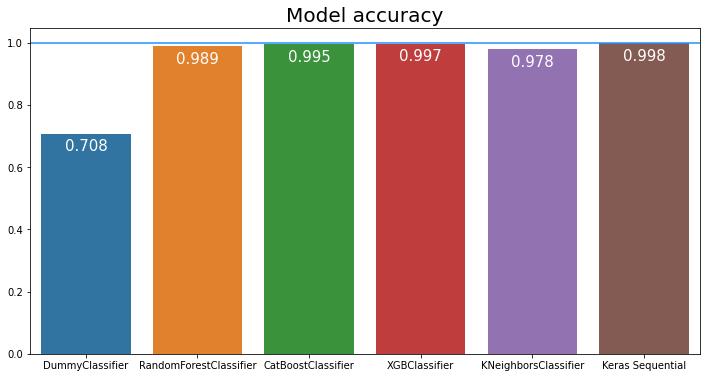

In [18]:
plt.figure(figsize=(12,6))
plt.ylim=(0,1)
plt.title('Model accuracy', fontsize=20)
ax = sns.barplot(x=list(result.keys()), y=list(result.values()))
ax.set_xticklabels(['DummyClassifier',
                    'RandomForestClassifier',
                    'CatBoostClassifier',
                    'XGBClassifier',
                    'KNeighborsClassifier',
                    'Keras Sequential'])

ax.bar_label(ax.containers[0], padding=-20, fontsize=15, fmt='%.3f', c='white')
plt.axhline(y=max(list(result.values())), c='dodgerblue') #max value line


Для окончательного прогноза будем использовать модельный ансамбль 

In [22]:
df_pred = df.drop('is_ultra', axis=1)
df['pred1'] = rfc.predict_proba(df_pred)[:,1]
df['pred2'] = cbc.predict_proba(df_pred)[:,1]
df['pred3'] = xgbc.predict_proba(df_pred)[:,1]
df['pred4'] = knc.predict(scaler.transform(df_pred))
print('Точность ансамбля обученных моделей :')
accuracy_score(df.is_ultra, df.iloc[:,-4:].mean(axis=1).round())

Точность ансамбля обученных моделей :


0.9972773239984442

## Выводы

Все рассматриваемые модели проходят проверку на "адекватность" и с высокой точность могут верно определить тариф для пользователя